In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

### Creating Minibatches Of Dataset

In [4]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed) 
    m = X.shape[1]
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:,mini_batch_size*(num_complete_minibatches):m]
        mini_batch_Y = shuffled_Y[:,mini_batch_size*(num_complete_minibatches):m]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

### Loading Dataset
The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.

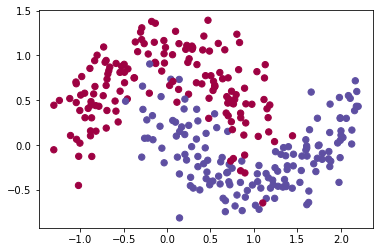

In [5]:
train_X, train_Y = load_dataset()

## Momentum
Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

Initialize the velocity. The velocity, $v$, is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the `grads` dictionary, that is:
for $l =1,...,L$:
```python
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```
**Note** that the iterator l starts at 0 in the for loop while the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript). This is why we are shifting l to l+1 in the `for` loop.

### Initializing Velocity

In [6]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W'+str(l+1)].shape[0],parameters['W'+str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b'+str(l+1)].shape[0],parameters['b'+str(l+1)].shape[1]))
        
    return v

### Update Parameters With Momentum

The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.

In [7]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        # compute velocities
        v["dW" + str(l+1)] = beta*v['dW'+str(l+1)]+(1-beta)*(grads['dW'+str(l+1)])
        v["db" + str(l+1)] = beta*v['db'+str(l+1)]+(1-beta)*(grads['db'+str(l+1)])
        
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]
        
    return parameters, v

### Model

In [8]:
def model(X,Y,layers_dims,learning_rate,mini_batch_size,beta,epochs):
    L = len(layers_dims)
    seed = 10                        
    m = X.shape[1]  
    
    parameters = initialize_parameters(layers_dims)
    
    v = initialize_velocity(parameters)
    
    for i in range(epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch
            
            AL, caches = forward_propagation(minibatch_X, parameters)
            
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            
        
    return parameters        

### Architecture

In [9]:
layers_dims = [train_X.shape[0], 5, 2, 1]

### Training

In [10]:
import time

In [11]:
tic = time.time()
final_parameters = model(train_X,train_Y,layers_dims,learning_rate=0.007,mini_batch_size=64,beta=0.9,epochs=10000)
toc = time.time()

print('Training time : ',toc-tic,'seconds')

Training time :  5.547382593154907 seconds


**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

### Predictions

In [12]:
predictions = predict(train_X, train_Y, final_parameters)

Accuracy: 0.9333333333333333


### Decision Boundry

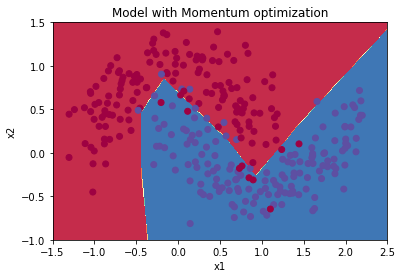

In [13]:
# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(final_parameters, x.T), train_X, train_Y)